# STEP 1: Import ALL the things!

In [43]:
import numpy as np
import pandas as pd 
## dealing with categorical variables
from sklearn.preprocessing import LabelEncoder 
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
app_train = pd.read_csv('application_train.csv')
app_train.shape

(307511, 122)

In [45]:
app_test = pd.read_csv('application_test.csv')

# STEP 2: EDA
### 2a. What's the distribution of target column?

In [46]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

### 2b. Are there missing values?

In [47]:
df_na = pd.DataFrame(app_train.isna().sum())
df_na['percent'] = (df_na[0] / app_train.shape[0]) *100
df_na.sort_values(by="percent", ascending = False)

0    percent
COMMONAREA_MEDI              214865  69.872297
COMMONAREA_AVG               214865  69.872297
COMMONAREA_MODE              214865  69.872297
NONLIVINGAPARTMENTS_MODE     213514  69.432963
NONLIVINGAPARTMENTS_AVG      213514  69.432963
NONLIVINGAPARTMENTS_MEDI     213514  69.432963
FONDKAPREMONT_MODE           210295  68.386172
LIVINGAPARTMENTS_MODE        210199  68.354953
LIVINGAPARTMENTS_AVG         210199  68.354953
LIVINGAPARTMENTS_MEDI        210199  68.354953
FLOORSMIN_AVG                208642  67.848630
FLOORSMIN_MODE               208642  67.848630
FLOORSMIN_MEDI               208642  67.848630
YEARS_BUILD_MEDI             204488  66.497784
YEARS_BUILD_MODE             204488  66.497784
YEARS_BUILD_AVG              204488  66.497784
OWN_CAR_AGE                  202929  65.990810
LANDAREA_MEDI                182590  59.376738
LANDAREA_MODE                182590  59.376738
LANDAREA_AVG                 182590  59.376738
BASEMENTAREA_MEDI            179943  58.515956
BASEMENTAREA_AVG             179943  58.515956
BASEMENTAREA_MODE            179943  58.515956
EXT_SOURCE_1                 173378  56.381073
NONLIVINGAREA_MODE           169682  55.179164
NONLIVINGAREA_AVG            169682  55.179164
NONLIVINGAREA_MEDI           169682  55.179164
ELEVATORS_MEDI               163891  53.295980
ELEVATORS_AVG                163891  53.295980
ELEVATORS_MODE               163891  53.295980
...                             ...        ...
AMT_CREDIT                        0   0.000000
AMT_INCOME_TOTAL                  0   0.000000
FLAG_PHONE                        0   0.000000
LIVE_CITY_NOT_WORK_CITY           0   0.000000
REG_CITY_NOT_WORK_CITY            0   0.000000
TARGET                            0   0.000000
REG_CITY_NOT_LIVE_CITY            0   0.000000
LIVE_REGION_NOT_WORK_REGION       0   0.000000
REG_REGION_NOT_WORK_REGION        0   0.000000
REG_REGION_NOT_LIVE_REGION        0   0.000000
HOUR_APPR_PROCESS_START           0   0.000000
WEEKDAY_APPR_PROCESS_START        0   0.000000
REGION_RATING_CLIENT_W_CITY       0   0.000000
REGION_RATING_CLIENT              0   0.000000
FLAG_EMAIL                        0   0.000000
FLAG_CONT_MOBILE                  0   0.000000
ORGANIZATION_TYPE                 0   0.000000
FLAG_WORK_PHONE                   0   0.000000
FLAG_EMP_PHONE                    0   0.000000
FLAG_MOBIL                        0   0.000000
DAYS_ID_PUBLISH                   0   0.000000
DAYS_REGISTRATION                 0   0.000000
DAYS_EMPLOYED                     0   0.000000
DAYS_BIRTH                        0   0.000000
REGION_POPULATION_RELATIVE        0   0.000000
NAME_HOUSING_TYPE                 0   0.000000
NAME_FAMILY_STATUS                0   0.000000
NAME_EDUCATION_TYPE               0   0.000000
NAME_INCOME_TYPE                  0   0.000000
SK_ID_CURR                        0   0.000000

[122 rows x 2 columns]

### 2bi -- Options for handling missing data
* imputation 
* XGBoost

### 2c. How will we handle our categorical variables?
* One-hot encoding?
* Labels?

Use `LabelEncoder` Labels for variables with categories < 2


In [48]:
# Create a label encoder object
# Iterate through the columns
# If 2 or fewer unique categories
# Train on the training data
# Transform both test and train

le = LabelEncoder()

for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

Use `pd.get_dummies` to do one-hot encoding for > 2

In [49]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

Remove excess columns created by the one-hot encoding

In [50]:
# Align the training and testing data, keep only columns present in both dataframes
# Add the target back in
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


### 2d. What should we do with outliers?

# STEP 3: Find relationships!

In [51]:
correlations = app_train.corr()['TARGET'].sort_values()

### 3a. Correlations
#### Positive Correlations

In [52]:
correlations.tail(20)

OCCUPATION_TYPE_Drivers                              0.030303
DEF_60_CNT_SOCIAL_CIRCLE                             0.031276
DEF_30_CNT_SOCIAL_CIRCLE                             0.032248
LIVE_CITY_NOT_WORK_CITY                              0.032518
OWN_CAR_AGE                                          0.037612
DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_R

#### Negative Correlations

In [53]:
correlations.head(20)

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
DAYS_EMPLOYED                          -0.044932
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
EMERGENCYSTATE_MODE_No                 -0.042201
HOUSETYPE_MODE_block of flats          -0.040594
AMT_GOODS_PRICE                        -0.039645
REGION_POPULATION_RELATIVE             -0.037227
ELEVATORS_AVG                          -0.034199
ELEVATORS_MEDI                         -0.033863
FLOORSMIN_AVG                          -0.033614
FLOORSMIN_MEDI                         -0.033394
WALLSMATERIAL_MODE_Panel               -0.033119
Name: TARGET, dtype:

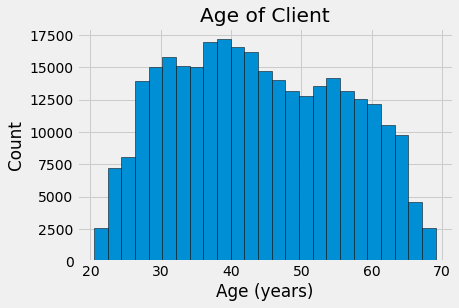

In [54]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
plt.style.use('fivethirtyeight')
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

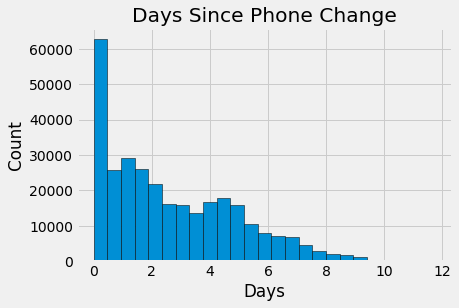

In [55]:
app_train['DAYS_LAST_PHONE_CHANGE'] = abs(app_train['DAYS_LAST_PHONE_CHANGE'])
plt.style.use('fivethirtyeight')
plt.hist(app_train['DAYS_LAST_PHONE_CHANGE'] / 365, edgecolor = 'k', bins = 25)
plt.title('Days Since Phone Change'); plt.xlabel('Days'); plt.ylabel('Count');

In [56]:
type(correlations.tail(20))

pandas.core.series.Series

In [57]:
high_corr = list(correlations.tail(20).axes[0])
high_corr

['OCCUPATION_TYPE_Drivers',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'LIVE_CITY_NOT_WORK_CITY',
 'OWN_CAR_AGE',
 'DAYS_REGISTRATION',
 'OCCUPATION_TYPE_Laborers',
 'FLAG_DOCUMENT_3',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_EMP_PHONE',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'REG_CITY_NOT_WORK_CITY',
 'DAYS_ID_PUBLISH',
 'CODE_GENDER_M',
 'DAYS_LAST_PHONE_CHANGE',
 'NAME_INCOME_TYPE_Working',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'DAYS_BIRTH',
 'TARGET']

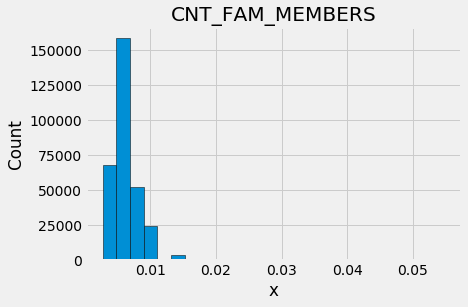

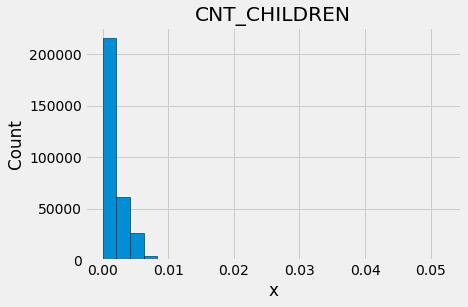

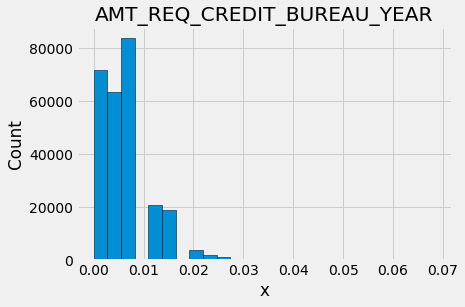

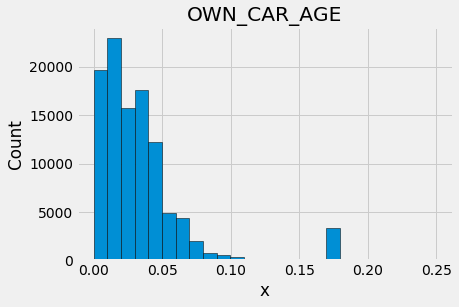

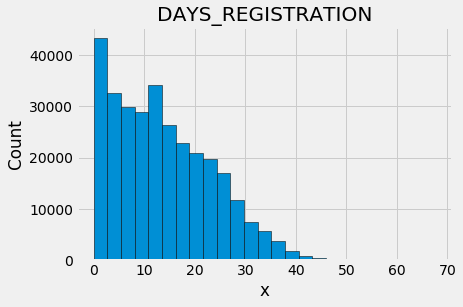

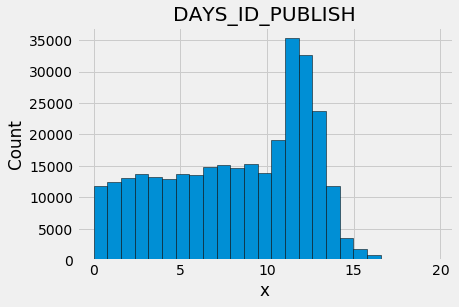

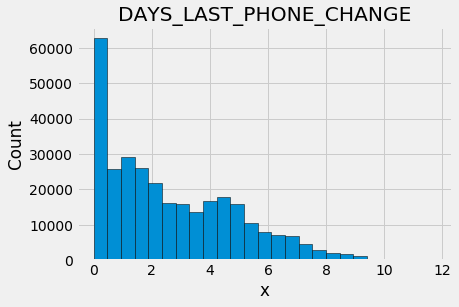

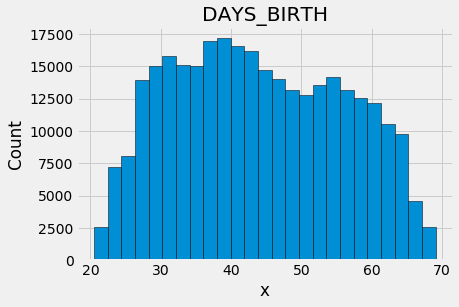

In [114]:
high_corr_for_graphs = ['CNT_FAM_MEMBERS',
 'CNT_CHILDREN',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OWN_CAR_AGE',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_BIRTH']

for col in high_corr_for_graphs:
#   print(app_train[col].value_counts())
#   print(app_train[col].dtype)
    df = app_train.copy()
    df[col] = abs(df[col])
    plt.style.use('fivethirtyeight')
    plt.hist(df[col] / 365, edgecolor = 'k', bins = 25)
    plt.title(col); plt.xlabel('x'); plt.ylabel('Count');
    plt.show()

### 3b. A closer look at age 
(using a Kernel Density Estimation Plot!!)

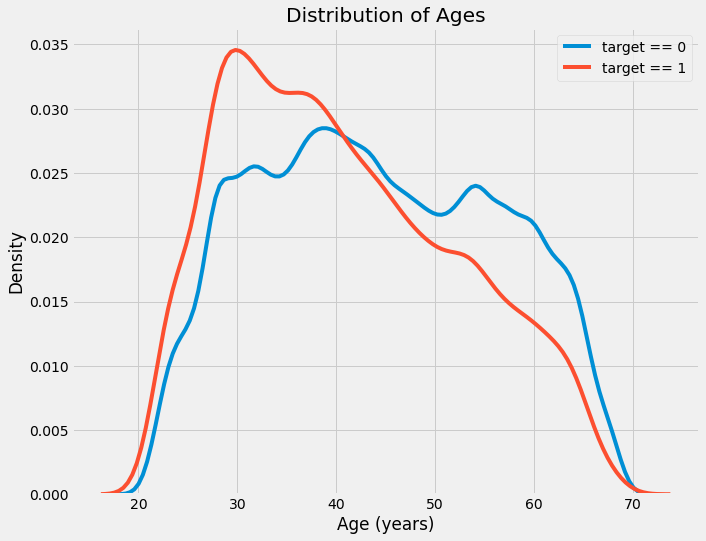

In [59]:

plt.figure(figsize = (10, 8))
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

#### Bin the age data

In [60]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 360

In [61]:
## This helps us get 20-25, 25-30 etc
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20,70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    26.280556  (25.0, 30.0]
1       0       16765    46.569444  (45.0, 50.0]
2       0       19046    52.905556  (50.0, 55.0]
3       0       19005    52.791667  (50.0, 55.0]
4       0       19932    55.366667  (55.0, 60.0]
5       0       16941    47.058333  (45.0, 50.0]
6       0       13778    38.272222  (35.0, 40.0]
7       0       18850    52.361111  (50.0, 55.0]
8       0       20099    55.830556  (55.0, 60.0]
9       0       14469    40.191667  (40.0, 45.0]

#### Group by the bin and get averages

In [62]:
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.125012   8463.267882    23.509077
(25.0, 30.0]  0.111014  10030.386730    27.862185
(30.0, 35.0]  0.104224  11694.933937    32.485928
(35.0, 40.0]  0.090733  13529.460855    37.581836
(40.0, 45.0]  0.078907  15290.154690    42.472652
(45.0, 50.0]  0.075157  17081.219691    47.447832
(50.0, 55.0]  0.068611  18922.643421    52.562898
(55.0, 60.0]  0.056411  20676.450120    57.434584
(60.0, 65.0]  0.053481  22453.060703    62.369613
(65.0, 70.0]  0.042640  24028.811895    66.746700

#### Plot our newly binned data

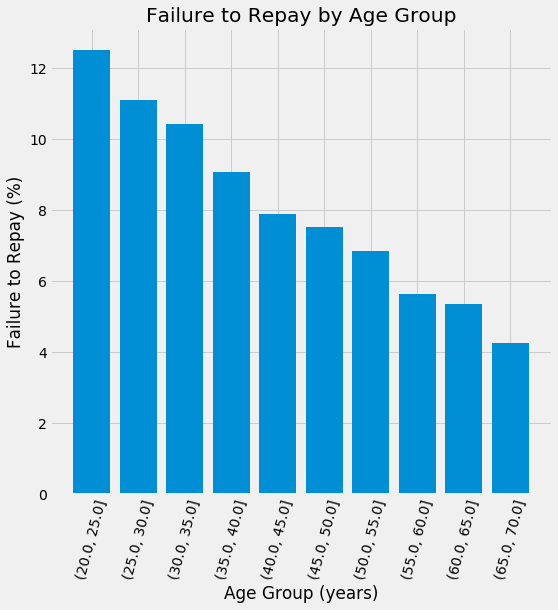

In [63]:
plt.figure(figsize=(8,8))
plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

# FIRST BIT OF INFORMATION FOR STAKEHOLDERS: 
"It appears that younger applicants are more likely to not repay their loans. Helping younger applicants with financial planning and guidance might help mitigate this" "

#### Exploring Negative Correlations

In [64]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

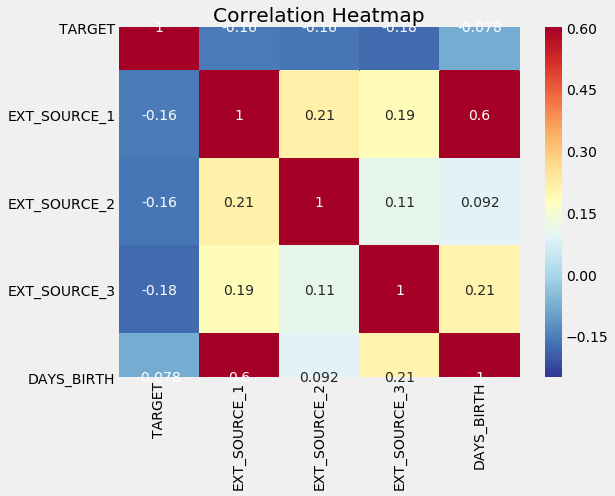

In [65]:
plt.figure(figsize = (8, 6))
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

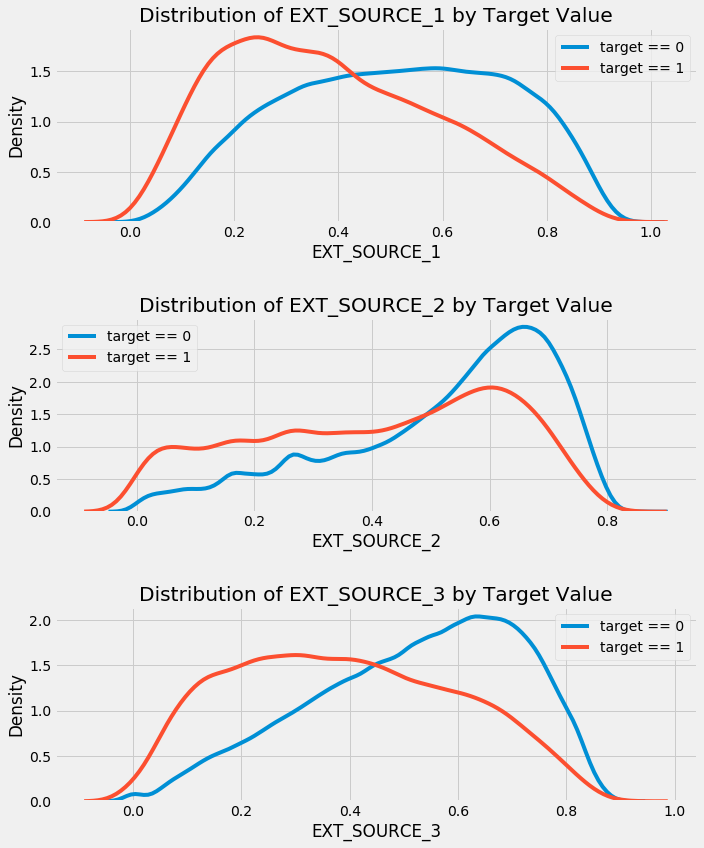

In [66]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

### Use Pair Plots to see relationships between multiple pairs of variables

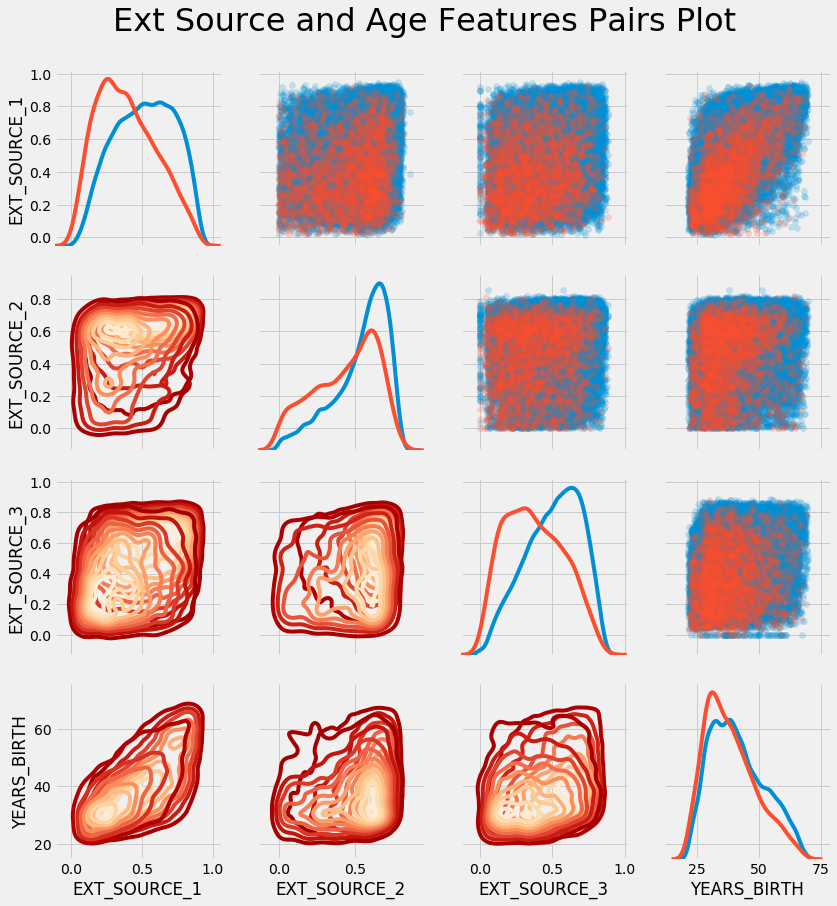

In [67]:
# Copy data, drop days_birth, add years_birth
# drop na and only get first 10k rows
# use corr_func to calc correlation coef b/t two cols

plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']
plot_data = plot_data.dropna().loc[:100000, :]

def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
# Upper is a scatter plot
# Diagonal is a histogram
# Bottom is density plot

grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])


grid.map_upper(plt.scatter, alpha = 0.2)
grid.map_diag(sns.kdeplot)
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);
plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

### RED =  LOAN NOT REPAID
### BLUE = LOAN REPAID

# FEATURE ENGINEERING

### Polynomial Features
Making features that are powers of existing features aka interaction terms 

1. Make a new DF for the polynomial features

In [68]:
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

2. Split target and features

In [69]:
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])

3. Handle missing values (using sklearn Imputer)

In [70]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

4. Create Polynomial Object

In [71]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree = 3)


5. Train the polynomial features & transform the features

In [72]:
poly_transformer.fit(poly_features)
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


### YAY!! New features!!

In [73]:
poly_transformer.get_feature_names(input_features = 
                                   ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

### Let's see if these are correlated with the target

In [74]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [75]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 274)
Testing data with polynomial features shape:   (48744, 274)


### Domain Knowledge Features
Inspired by [this](https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features)

In [76]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

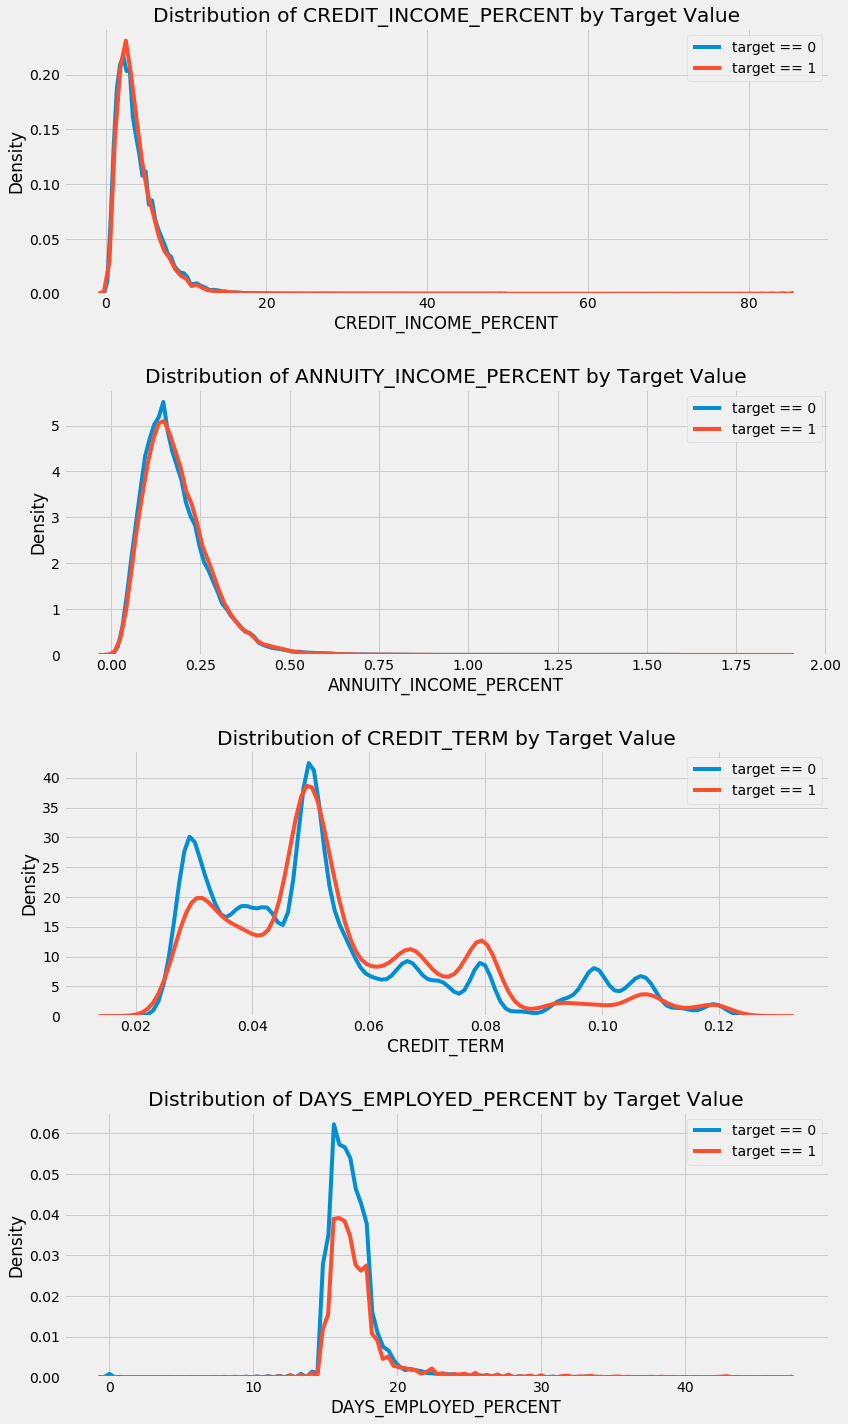

In [77]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

### BRIEF SIDEQUEST TO EXAMINE TEST DATA & PLAY WITH SAMPLING

In [95]:
# app_train['TARGET'].value_counts()
# only_0 = app_train[app_train['TARGET'] == 0]
# only_0['TARGET'].value_counts()
# # only_0.isna().sum()
# only_0[pd.isnull(only_0).any(axis=1)]
# sample = only_0.sample(n=24825, random_state=1)
# app_test.isna().sum()

# df_na = pd.DataFrame(app_test.isna().sum())
# df_na['percent'] = (df_na[0] / app_train.shape[0]) *100
# df_na.sort_values(by="percent", ascending = False)

# df_na = pd.DataFrame(sample.isna().sum())
# df_na['percent'] = (df_na[0] / df.shape[0]) *100
# df_na.sort_values(by="percent", ascending = False)

# BASELINE
## Logistic Regression

In [96]:
# Drop the target from the training data
# Feature names
# Copy of the testing data
# Median imputation of missing values
# Scale each feature to 0-1
# Fit on the training data
# Transform both training and testing data
# Repeat with the scaler

from sklearn.preprocessing import MinMaxScaler, Imputer

if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
features = list(train.columns)
test = app_test.copy()

imputer = Imputer(strategy = 'median')
scaler = MinMaxScaler(feature_range = (0, 1))
imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(app_test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


In [97]:
# Make the model with the specified regularization parameter
# Train on the training data

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [98]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [99]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

SK_ID_CURR    TARGET
0      100001  0.092182
1      100005  0.166676
2      100013  0.113882
3      100028  0.080417
4      100038  0.160281

In [100]:
submit.to_csv('log_reg_baseline.csv', index = False)

#### ==== RESULTS =====
* LOGISTIC REGRESSION: 0.67493

## RANDOM FOREST

In [101]:
# Make the random forest classifier
# Train on the training data
# Extract feature importances
# Make predictions on the test data

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

random_forest.fit(train, train_labels)

feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


In [102]:
# Make a submission dataframe
# Save the submission dataframe

submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

submit.to_csv('random_forest_baseline.csv', index = False)

#### ==== RESULTS =====
* LOGISTIC REGRESSION: 0.67493
* RANDOM FOREST: 0.67727

### RANDOM FOREST + ENGINEERED FEATURES

In [103]:
# Impute the polynomial features
# Scale the polynomial features
# Train on the training data
# Make predictions on the test data

poly_features_names = list(app_train_poly.columns)

imputer = Imputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest_poly.fit(poly_features, train_labels)
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

submit.to_csv('random_forest_baseline_engineered.csv', index = False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


### Testing Domain Features

In [105]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = Imputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


In [106]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_domain.csv', index = False)

In [107]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

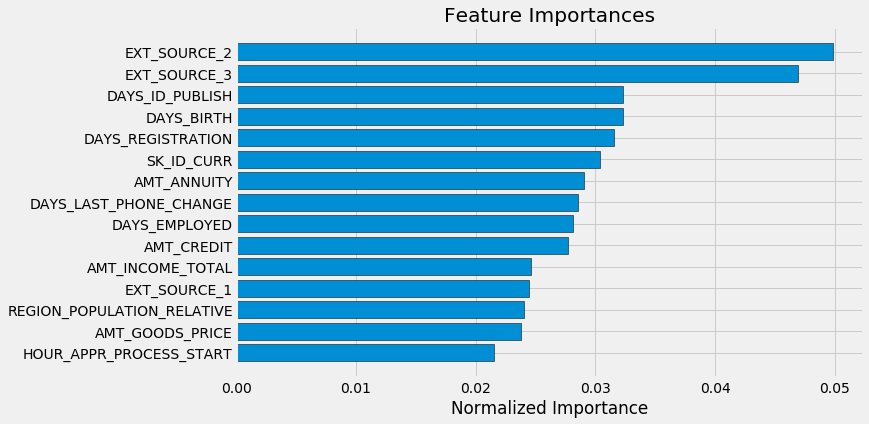

In [110]:
feature_importances_sorted = plot_feature_importances(feature_importances)


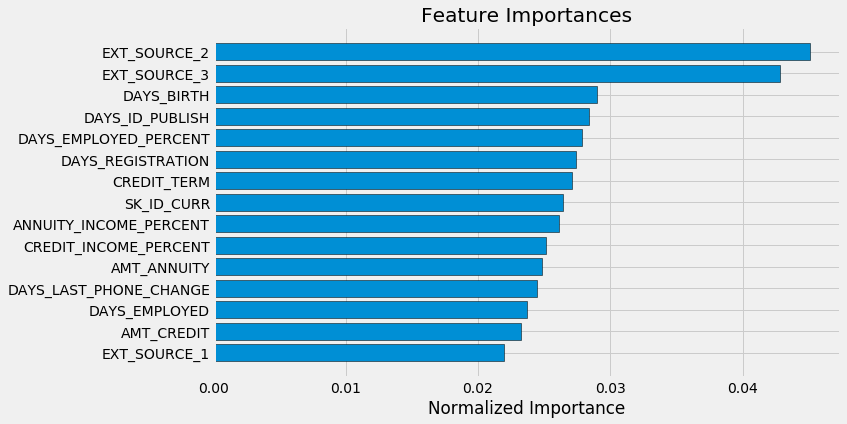

In [111]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)


In [108]:
### Light Gradient Boosting

In [120]:
!pip install lightgbm
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

  Using cached https://files.pythonhosted.org/packages/21/d1/7773d81964183f6892f71cf43b92f90d0bb8c954c05651d5071a2b480420/lightgbm-2.3.1-py2.py3-none-macosx_10_9_x86_64.macosx_10_10_x86_64.macosx_10_11_x86_64.macosx_10_12_x86_64.macosx_10_13_x86_64.macosx_10_14_x86_64.macosx_10_15_x86_64.whl
Training Data Shape:  (307511, 238)
Testing Data Shape:  (48744, 238)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798883	train's binary_logloss: 0.547748	valid's auc: 0.75494	valid's binary_logloss: 0.563082
Early stopping, best iteration is:
[221]	train's auc: 0.802204	train's binary_logloss: 0.544483	valid's auc: 0.755025	valid's binary_logloss: 0.561067
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798978	train's binary_logloss: 0.547699	valid's auc: 0.7586	valid's binary_logloss: 0.563237
Early stopping, best iteration is:
[230]	train's auc: 0.804075	train's binary_logloss: 0.542728	valid's auc: 0.758786	valid's binary_

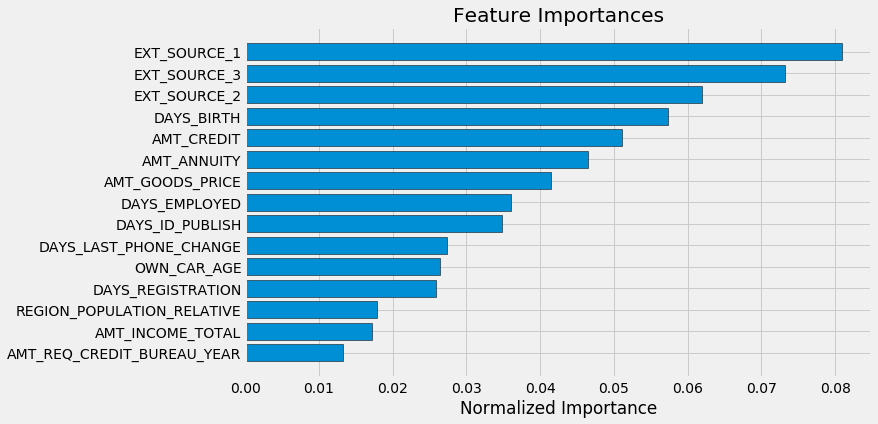

In [121]:
fi_sorted = plot_feature_importances(fi)


In [122]:
submission.to_csv('baseline_lgb.csv', index = False)


In [123]:
app_train_domain['TARGET'] = train_labels

# Test the domain knolwedge features
submission_domain, fi_domain, metrics_domain = model(app_train_domain, app_test_domain)
print('Baseline with domain knowledge features metrics')
print(metrics_domain)

Training Data Shape:  (307511, 242)
Testing Data Shape:  (48744, 242)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.804581	train's binary_logloss: 0.541636	valid's auc: 0.76186	valid's binary_logloss: 0.557395
Early stopping, best iteration is:
[186]	train's auc: 0.802208	train's binary_logloss: 0.544117	valid's auc: 0.761952	valid's binary_logloss: 0.558741
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.803808	train's binary_logloss: 0.542495	valid's auc: 0.766178	valid's binary_logloss: 0.557661
Early stopping, best iteration is:
[222]	train's auc: 0.80737	train's binary_logloss: 0.538788	valid's auc: 0.766491	valid's binary_logloss: 0.555377
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.803238	train's binary_logloss: 0.543375	valid's auc: 0.770764	valid's binary_logloss: 0.558325
[400]	train's auc: 0.83307	train's binary_logloss: 0.512881	valid's auc: 0.771205	valid's binary

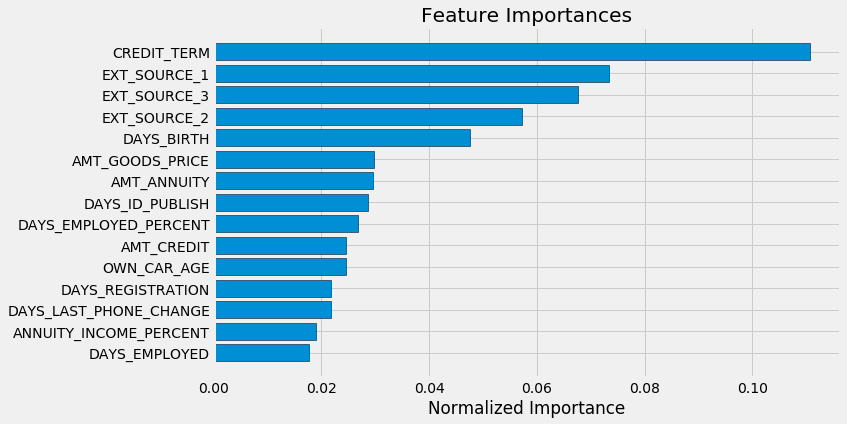

In [124]:
fi_sorted = plot_feature_importances(fi_domain)


submission_domain.to_csv('baseline_lgb_domain_features.csv', index = False)
